In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.5.0


In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'../imagens'
BATCH_SIZE = 24 * strategy.num_replicas_in_sync
IMAGE_SIZE = [460, 700]
EPOCHS = 25

In [3]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/40X_treino/*/*'))
train_filenames = filenames

In [4]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

In [5]:
for f in train_list_ds.take(5):
    print(f.numpy())

b'..\\imagens\\40X_treino\\B\\A1.png'
b'..\\imagens\\40X_treino\\B\\A10.png'
b'..\\imagens\\40X_treino\\B\\A11.png'
b'..\\imagens\\40X_treino\\B\\A12.png'
b'..\\imagens\\40X_treino\\B\\A13.png'


In [6]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + '/40X_treino/*'))])
CLASS_NAMES

array(['B', 'M'], dtype='<U1')

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "M"

In [8]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [9]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (460, 700, 3)
Label:  False


In [49]:
# matar esse
# test_list_ds = tf.data.Dataset.list_files(r'C:\Users\rodrigo.cabral\PycharmProjects\TCC-CienciaDados\Imagens\40X_treino/*/*')
# TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
# test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE)

# TEST_IMAGE_COUNT

In [12]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [13]:
train_ds = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(train_ds))

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("M")
        else:
            plt.title("B")
        plt.axis("off")

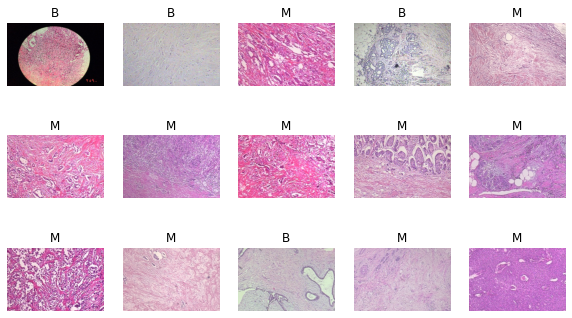

In [15]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        tf.keras.layers.Dropout(0.2),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        dense_block(32, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 460, 700, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 460, 700, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 230, 350, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 115, 175, 32)      2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 57, 87, 64)        7392      
_________________________________________________________________
dropout (Dropout)            (None, 57, 87, 64)        0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 43, 128)      

In [23]:
def contar_arquivos(path):
    for p, _, files in os.walk(os.path.abspath(path)):
        return len(files)
        break


COUNT_B = contar_arquivos(r'C:\Users\rodrigo.cabral\PycharmProjects\TCC-CienciaDados\Imagens\40X_treino\B')
COUNT_M = contar_arquivos(r'C:\Users\rodrigo.cabral\PycharmProjects\TCC-CienciaDados\Imagens\40X_treino\M')

print(f'Numero de Benignos {COUNT_B}\n Numero de Malignos {COUNT_M}')

Numero de Benignos 463
 Numero de Malignos 880


In [24]:
initial_bias = np.log([COUNT_M/COUNT_B])
initial_bias

array([0.64219485])

In [25]:
weight_for_0 = (1 / COUNT_B)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_M)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.45
Weight for class 1: 0.76


In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()

history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
55/55 [==============================] - 407s 7s/step - loss: 0.6094 - accuracy: 0.7083 - precision: 0.8152 - recall: 0.7182
Epoch 2/25
55/55 [==============================] - 415s 8s/step - loss: 0.5493 - accuracy: 0.7447 - precision: 0.8297 - recall: 0.7629
Epoch 3/25
55/55 [==============================] - 427s 8s/step - loss: 0.5164 - accuracy: 0.7629 - precision: 0.8581 - recall: 0.7661
Epoch 4/25


In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall'])

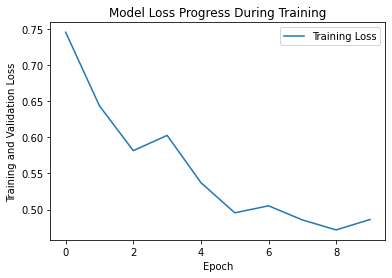

In [61]:
plt.plot(history.history['loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss']);

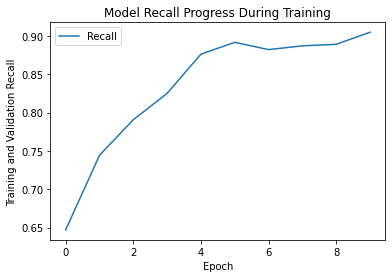

In [62]:
plt.plot(history.history['recall'])
plt.title('Model Recall Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Recall')
plt.legend(['Recall']);

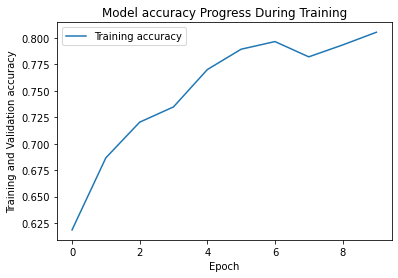

In [63]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation accuracy')
plt.legend(['Training accuracy']);

In [64]:
# matar esse
test_list_ds = tf.data.Dataset.list_files(r'C:\Users\rodrigo.cabral\PycharmProjects\TCC-CienciaDados\Imagens\40x_Teste\*\*')
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

745

In [65]:
loss, acc, prec, rec = model.evaluate(test_ds)

32/32 [==============================] - 10s 286ms/step - loss: 0.6431 - accuracy: 0.6577 - precision: 0.6577 - recall: 1.0000


In [38]:
from sklearn.metrics import confusion_matrix